# 1.2 Symbol Recognition with a CNN - Training the Model

In this notebook, we train a convolutional neural network that is capable of detecting mathematical symbols. Note that main goal of this exploration is to get a sense for what type of model might be a reasonable encoder for our seq2seq model. After all, the encoder must be able to effectively represent the various mathematical symbols present in formulas. In some ways, the formula problem is easier -- since the input formulas are not handwritten -- and in some ways it is a harder problem -- since formulas can be quite long and complex. In any case, this exploration will serve as a reasonable starting point.

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt

import random 

In [10]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

2.0.0-beta1
False
False



In [11]:
import os

### Make sure our data is in order
data_base_dir = "../data"
figs_base_dir = "../figs"
model_base_dir = "../models"

original_data_path = data_base_dir + "/original/symbol/"
processed_data_path = data_base_dir + "/processed/symbol/"
pickle_data_path = data_base_dir + "/pickle/symbol/"
model_data_path = model_base_dir + "/symbol"

assert os.path.exists(original_data_path), "Original data path does not exist."
assert os.path.isdir(processed_data_path), "Original data path exists, but is not a directory."

if not os.path.exists(processed_data_path):
    print("Creating processed data path...")
    os.mkdir(processed_data_path)    

## Load data

Below, we unpickle the data.

In [12]:
import pickle 

with open(f"{pickle_data_path}labels.pickle", 'rb') as handle:
    unique_labels = pickle.load(handle)
    unique_labels.sort()

with open(f"{pickle_data_path}train_labels.pickle", 'rb') as handle:
    train_labels = pickle.load(handle)
    
with open(f"{pickle_data_path}train_images.pickle", 'rb') as handle:
    train_images = pickle.load(handle)
    
with open(f"{pickle_data_path}test_labels.pickle", 'rb') as handle:
    test_labels = pickle.load(handle)
    
with open(f"{pickle_data_path}test_images.pickle", 'rb') as handle:
    test_images = pickle.load(handle)
    
print("Data loading complete.")
print(f"Got {len(train_images)} training images and {len(train_labels)} labels.")
print(f"Got {len(test_images)} test images and {len(test_labels)} labels.")
print(f"Found {len(unique_labels)} total unique labels.")

Data loading complete.
Got 51 training images and 51 labels.
Got 31 test images and 31 labels.
Found 101 total unique labels.


Next, plot some sample images from the training dataset:

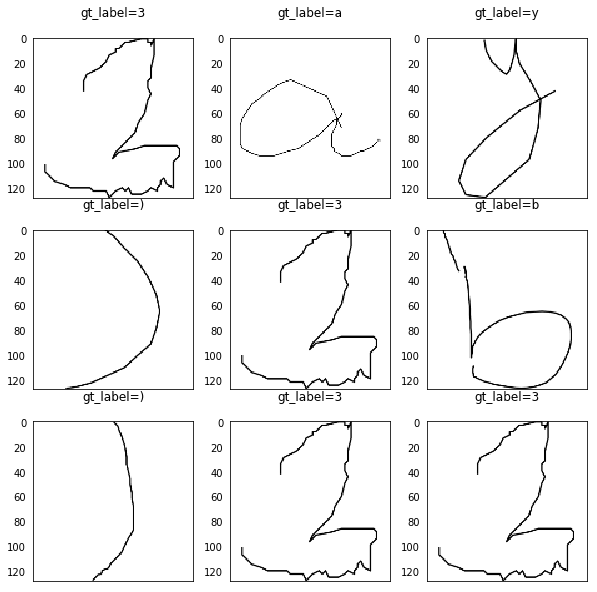

In [13]:
import random 

def plot_indices(indices, images, labels, label_category_names, size=(128,128), metadata=None, save=False, name=None):   
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
    index = 0
    for row in ax:
        for col in row:
            # Get image & label
            idx = indices[index]
            image = tf.reshape(images[idx], size)
            label = labels[idx]

            if metadata is not None:
                meta = f"meta={metadata[index]}"
            else:
                meta = ''
                    

            col.tick_params(
                axis='both',        
                which='both',
                left=False,
                right=False,
                bottom=False,
                top=False,   
                labelbottom=False,
            )
            col.imshow(image, cmap='gray', vmin=0, vmax=1.0)
            col.set_title(f"gt_label={label}\n{meta}")

            index += 1
            
    if save and name is not None:
        print("Saving figure...")
        plt.savefig(name)
        
# Plot some random images
random_indices = [random.randint(0, len(train_images)) for i in range(0,9)]
plot_indices(random_indices, train_images, train_labels, unique_labels)

In [14]:
# Convert from label to category
train_cat = [unique_labels.index(label) for label in train_labels]
test_cat = [unique_labels.index(label) for label in test_labels]

### Simple Binary classification model

As a basic sanity check, lets train a simple binary classication model that predicts if an image contains a '-' symbol.
We will use a model with 2 dense layers trained with the Adam optimizer and a binary cross-entropy loss function (as appropriate for binary classifcation).
The performance of this model should provide an upper bound on the performance we can expect for a k-class classification model.

In [15]:
from tensorflow.keras import models, layers

#####################################
#### Binary classification model ####
#####################################

learning_rate = 0.0001
size = (128,128)
# if model is not None:
#     del model
    
model = models.Sequential([
    layers.Flatten(input_shape=(size[0], size[1])),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


model.summary()

model.compile(optimizer=tf.optimizers.Adam(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

binary_train_labels = [1 if unique_labels[label] == '-' else 0 for label in train_cat]
binary_test_labels = [1 if unique_labels[label] == '-' else 0 for label in test_cat]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,097,409
Trainable params: 2,097,409
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(
    train_images, 
    binary_train_labels, 
    validation_data=(test_images, binary_test_labels),
    batch_size=32,
    epochs=50)

W0804 15:17:22.177819 4499281344 deprecation.py:323] From /Users/erikbeerepoot/.virtualenvs/ml-tf1/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 51 samples, validate on 31 samples
Epoch 1/50
51/51 [==============================] - 0s 7ms/sample - loss: 0.5354 - accuracy: 0.4706 - val_loss: 1.8241 - val_accuracy: 0.8710
Epoch 2/50
51/51 [==============================] - 0s 348us/sample - loss: 1.1593 - accuracy: 0.9216 - val_loss: 1.9903 - val_accuracy: 0.8710
Epoch 3/50
51/51 [==============================] - 0s 371us/sample - loss: 1.2098 - accuracy: 0.9216 - val_loss: 1.9903 - val_accuracy: 0.8710
Epoch 4/50
51/51 [==============================] - 0s 372us/sample - loss: 1.2098 - accuracy: 0.9216 - val_loss: 1.9903 - val_accuracy: 0.8710
Epoch 5/50
51/51 [==============================] - 0s 431us/sample - loss: 1.2098 - accuracy: 0.9216 - val_loss: 1.9903 - val_accuracy: 0.8710
Epoch 6/50
51/51 [==============================] - 0s 399us/sample - loss: 1.2098 - accuracy: 0.9216 - val_loss: 1.9903 - val_accuracy: 0.8710
Epoch 7/50
51/51 [==============================] - 0s 393us/sample - loss: 1.2098 - accuracy:

In [17]:
import pandas as pd
def plot_history(history, filename=None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Validation accuracy')

    plt.title("Figure 2: Training and validation loss vs. Epoch")
    plt.legend()

    if filename is not None:
        plt.savefig(filename)        
        
    plt.show()

From the training plot below, at 50 epochs, we can see the training curve has not quite levelled out. Hence,
we can improve our results by increasing the training time.

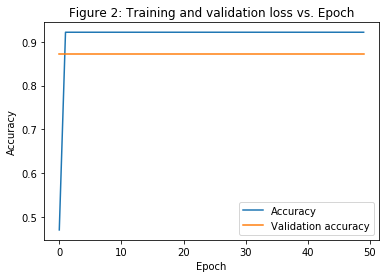

In [18]:
plot_history(history, f"{figs_base_dir}/symbol-simple-accuracy.pdf")

Now, let's plot some sample predictions along with the ground truth labels and associated confidence to empirically gauge
the quality of the predictions made. On each of the subplots, the ground truth label is denoted by `gt_label` and `meta` indicates the confidence that this particular symbol is a `-`. Trained on enough data, the network can make reasonable predictions.

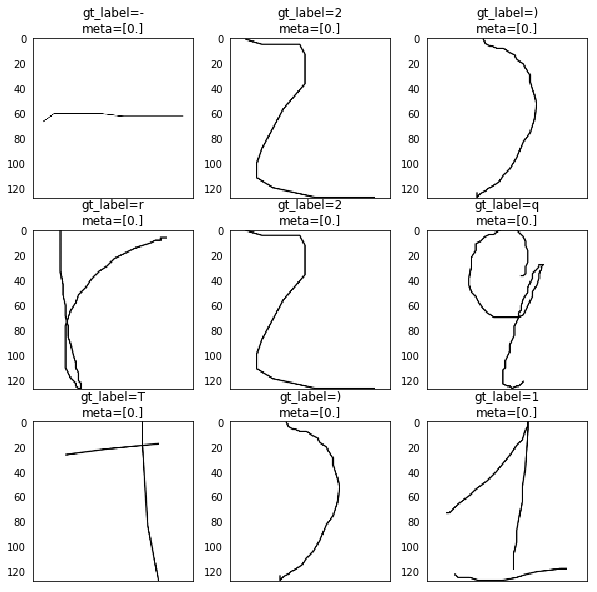

In [26]:
# Select some random images from the training set
random_indices = [random.randint(0, len(test_images)) for i in range(0,9)]

# Predict the labels
random_images = np.array([test_images[idx] for idx in random_indices])
predictions = model.predict(random_images)

# Plot
plot_indices(random_indices, test_images, test_labels, unique_labels, metadata=predictions)

We can observe that the model is able to predict the correct label with confidence, but is prone to false positives.

Now, let's try a more complicated model.

## Binary classification with Convolutional Neural nets

In [27]:
# Add CNNs for features
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size[0], size[1], 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers for classification
conv_model.add(layers.Flatten(input_shape=(size[0], size[1], 1)))
conv_model.add(layers.Dense(25, activation='relu'))
conv_model.add(layers.Dense(1, activation='sigmoid'))

conv_model.compile(optimizer=tf.optimizers.Adam(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)               

In [28]:
img_train = np.expand_dims(train_images,axis=3)
img_test = np.expand_dims(test_images,axis=3)

conv_history = conv_model.fit(
    img_train, 
    binary_train_labels, 
    validation_data=(img_test, binary_test_labels),
    batch_size=32,
    epochs=50)

Train on 51 samples, validate on 31 samples
Epoch 1/50
51/51 [==============================] - 1s 15ms/sample - loss: 0.7524 - accuracy: 0.4510 - val_loss: 0.5449 - val_accuracy: 0.8710
Epoch 2/50
51/51 [==============================] - 0s 8ms/sample - loss: 0.4949 - accuracy: 0.9216 - val_loss: 0.4518 - val_accuracy: 0.8710
Epoch 3/50
51/51 [==============================] - 0s 7ms/sample - loss: 0.3851 - accuracy: 0.9216 - val_loss: 0.3979 - val_accuracy: 0.8710
Epoch 4/50
51/51 [==============================] - 0s 8ms/sample - loss: 0.3176 - accuracy: 0.9216 - val_loss: 0.3839 - val_accuracy: 0.8710
Epoch 5/50
51/51 [==============================] - 0s 9ms/sample - loss: 0.2775 - accuracy: 0.9216 - val_loss: 0.4011 - val_accuracy: 0.8710
Epoch 6/50
51/51 [==============================] - 0s 9ms/sample - loss: 0.2720 - accuracy: 0.9216 - val_loss: 0.4332 - val_accuracy: 0.8710
Epoch 7/50
51/51 [==============================] - 0s 9ms/sample - loss: 0.2822 - accuracy: 0.9216 - v

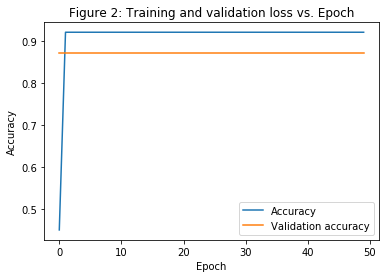

In [30]:
plot_history(conv_history, f"{figs_base_dir}/symbol-conv-accuracy.pdf")

Again, we plot some examples with the ground truth label, and the confidence that this is a `-` symbol. This model performs better.

/Users/erikbeerepoot/.virtualenvs/ml-tf1/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


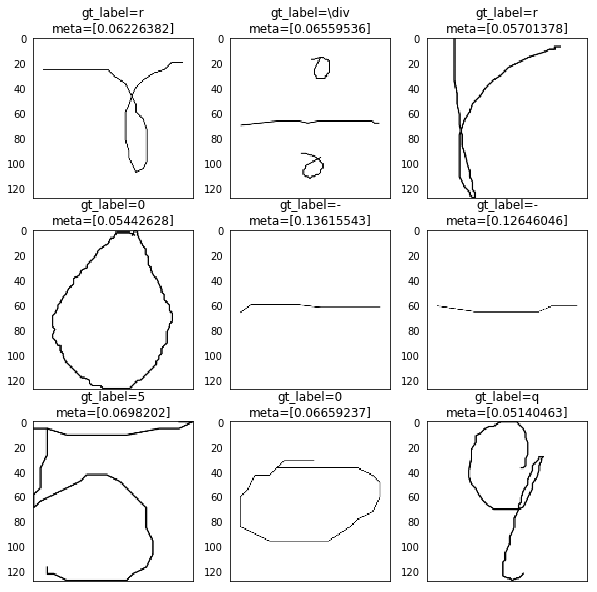

In [33]:
# Select some random images from the training set
random_indices = [random.randint(0, len(test_images) - 1) for i in range(0,9)]

# Predict the labels
random_images = np.array([test_images[idx] for idx in random_indices])
random_images = np.expand_dims(random_images,axis=4)
predictions = conv_model.predict(random_images)

# Plot
plot_indices(random_indices, test_images, test_labels, unique_labels, metadata=predictions)

## Multi-class classification with Convolutional Neural nets

Using convolutional layers led to a increase in the accuracy of the model (of almost 4%). Emperically, the confidence level of the predictions in a given prediction has also increased -- the model is more sure about both positive and negative predicitions. Next, we will try to applying this same model but predict additional classes.

Here, we'll use sparse categorical cross entropy -- this loss is appropriate when losses are computed over k classes, and labels are provided as integers. 

First, compute those labels:

In [34]:
train_labels_cat = [unique_labels.index(label) for label in train_labels]
test_labels_cat = [unique_labels.index(label) for label in test_labels]

Next, create our deep convolutional model. Note the use of the softmax activation in the last layer
with the number of units equal to the number of classes.

In [35]:
from tensorflow.keras import metrics 

# Add CNNs for features
k_conv_model = models.Sequential()
k_conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size[0], size[1], 1)))
k_conv_model.add(layers.MaxPooling2D((2, 2)))
k_conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
k_conv_model.add(layers.MaxPooling2D((2, 2)))
k_conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers for classification
k_conv_model.add(layers.Flatten(input_shape=(size[0], size[1], 1)))
k_conv_model.add(layers.Dense(25, activation='relu'))
k_conv_model.add(layers.Dense(len(unique_labels), activation='softmax'))

k_conv_model.compile(optimizer=tf.optimizers.Adam(learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[metrics.sparse_categorical_accuracy])

k_conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)               

Finally, let's train our model:

In [36]:
k_conv_model_history = k_conv_model.fit(
    img_train, 
    train_labels_cat, 
    validation_data=(img_test, test_labels_cat),
    batch_size=32,
    epochs=50)

Train on 51 samples, validate on 31 samples
Epoch 1/50
51/51 [==============================] - 1s 17ms/sample - loss: 4.6330 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.5622 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/50
51/51 [==============================] - 0s 9ms/sample - loss: 4.5873 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.5298 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/50
51/51 [==============================] - 0s 9ms/sample - loss: 4.5629 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.5059 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/50
51/51 [==============================] - 0s 9ms/sample - loss: 4.5504 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.4915 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/50
51/51 [==============================] - 0s 8ms/sample - loss: 4.5444 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.4814 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/50
51/5

One more time, we plot some examples picked from the test set along with ground truth and predictions. The model does pretty well. 
We will try to use this architecture as the encoder for our seq2seq model.

/Users/erikbeerepoot/.virtualenvs/ml-tf1/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


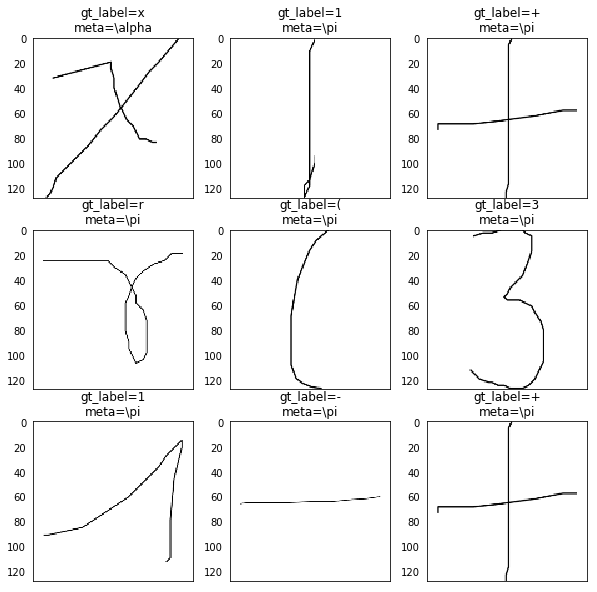

In [38]:
# Select some random images from the training set
random_indices = [random.randint(0, len(test_images) - 1) for i in range(0,9)]

# Predict the labels
random_images = np.array([test_images[idx] for idx in random_indices])
random_images = np.expand_dims(random_images,axis=4)
predictions = k_conv_model.predict(random_images)

# Get the label of the highest confidence predictions
max_prediction_labels = []
for prediction in predictions:
    max_prediction = np.max(prediction)
    index_of_max = np.where(prediction == np.max(prediction))[0][0]
    max_prediction_labels.append(unique_labels[index_of_max])

# Plot some sample predictions
plot_indices(random_indices, test_images, test_labels, unique_labels, metadata=max_prediction_labels)